## Indice de Végétation Normalisé (NDVI)

### Description de l’indicateur

Le **NDVI (Normalized Difference Vegetation Index)** est un indice spectral de
télédétection largement utilisé pour **caractériser la présence, la densité et
l’état physiologique de la végétation** à la surface terrestre.

Il repose sur une **propriété biophysique fondamentale des plantes vertes** :
la **chlorophylle** absorbe fortement le rayonnement dans le **rouge** pour les
besoins de la photosynthèse, tandis que la structure interne des feuilles
réfléchit fortement le rayonnement dans le **proche infrarouge (NIR)**.

Ainsi, plus la végétation est **dense, saine et photosynthétiquement active**,
plus la différence entre la réflectance dans le proche infrarouge et celle dans
le rouge est élevée.

Les valeurs du NDVI sont comprises entre **−1 et +1** :

- **NDVI < 0** : surfaces non végétalisées, principalement l’eau, certaines
  surfaces artificialisées ou zones très sombres ;
- **NDVI proche de 0 (≈ 0 à 0.2)** : sols nus, zones faiblement végétalisées,
  surfaces désertiques ou rocheuses ;
- **NDVI intermédiaire (≈ 0.2 à 0.4)** : végétation clairsemée, cultures en début
  ou en fin de cycle végétatif ;
- **NDVI élevé (> 0.4)** : végétation dense, vigoureuse et active
  photosynthétiquement (forêts, cultures en pleine croissance).

Le NDVI est couramment mobilisé pour :
- le suivi spatio-temporel de la végétation et des cultures ;
- l’analyse de la productivité végétale ;
- la détection du stress hydrique et de la dégradation environnementale ;
- les études sur la sécheresse et la variabilité climatique.

---

### Méthodologie de calcul

Le NDVI est calculé à partir des images multispectrales du satellite
**Sentinel-2**, qui offrent une résolution spatiale et spectrale adaptée à
l’analyse de la végétation.

Les bandes spectrales utilisées sont :

- **B4 (Rouge)** : bande centrée autour de **665 nm**, fortement absorbée par la
  chlorophylle ;
- **B8 (Proche infrarouge – NIR)** : bande centrée autour de **842 nm**, fortement
  réfléchie par la structure cellulaire des feuilles.

Ces bandes sont généralement exploitées à une **résolution spatiale de 10 m**
ou agrégées à une résolution plus grossière selon l’objectif de l’étude.

Le NDVI est défini par la relation suivante :

$$
NDVI = \frac{NIR - Red}{NIR + Red}
$$

où :
- $NIR$ représente la réflectance de la bande **B8** ;
- $Red$ représente la réflectance de la bande **B4**.

La normalisation de l’indice permet :
- de réduire l’influence des conditions d’illumination et de la topographie ;
- de faciliter la comparaison spatiale et temporelle des valeurs ;
- d’obtenir un indicateur adimensionnel borné entre −1 et +1.

---


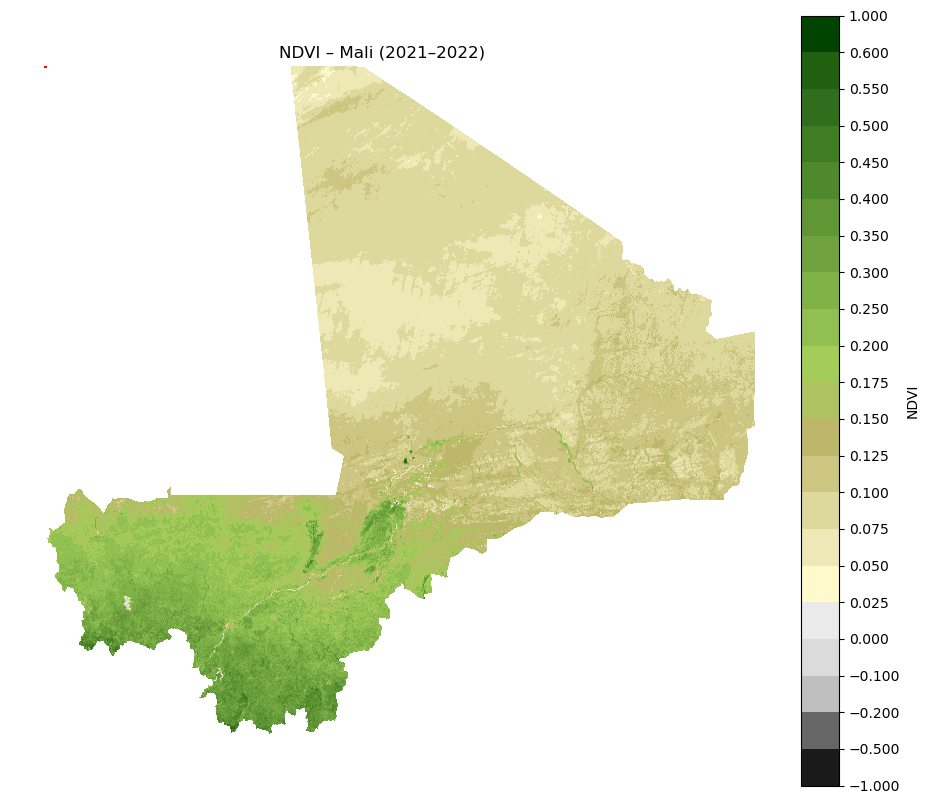

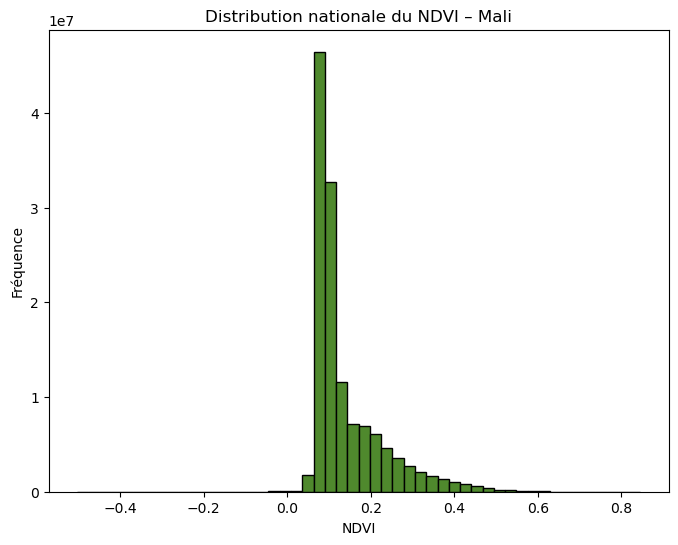

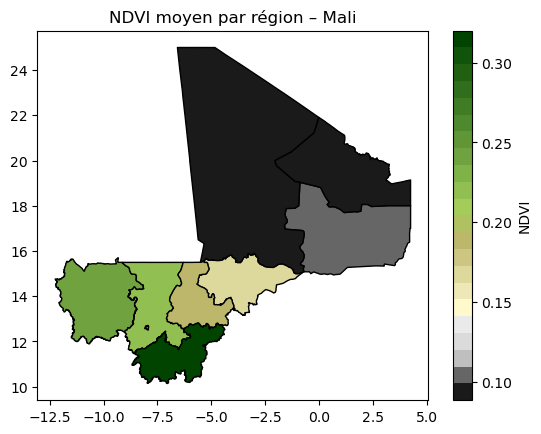

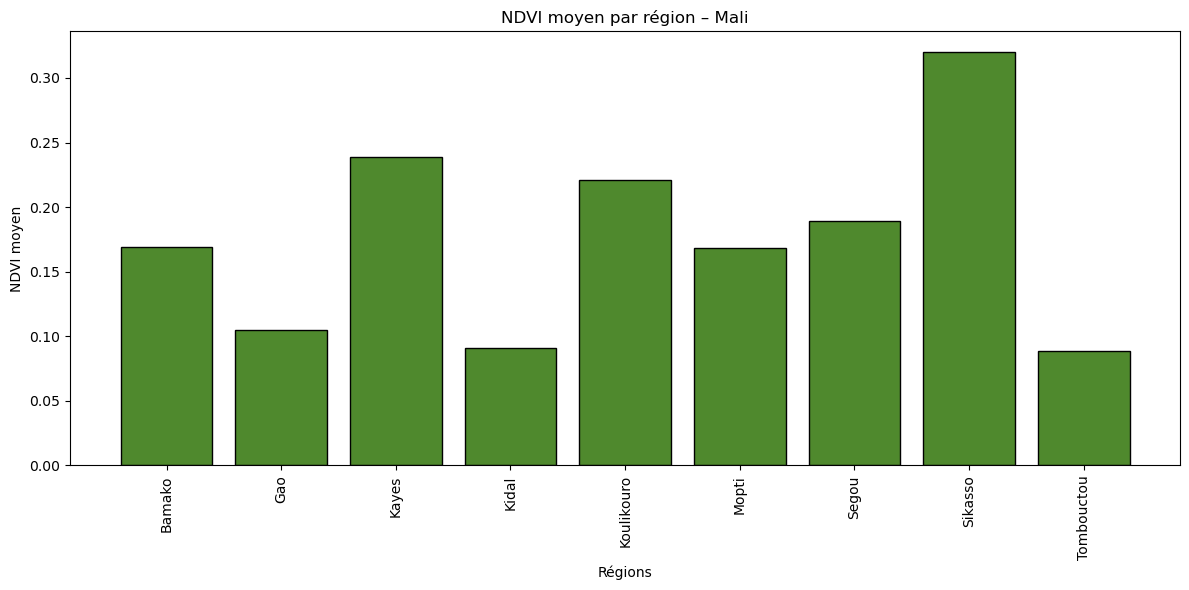

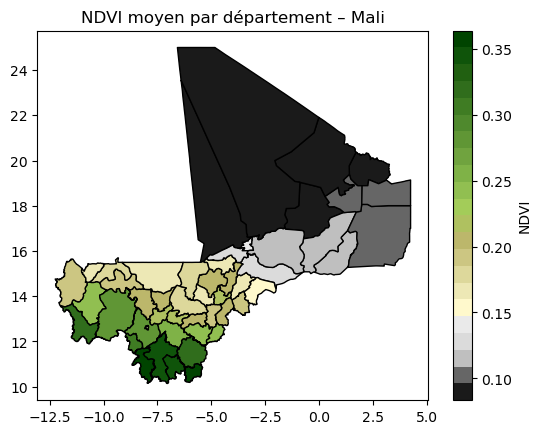

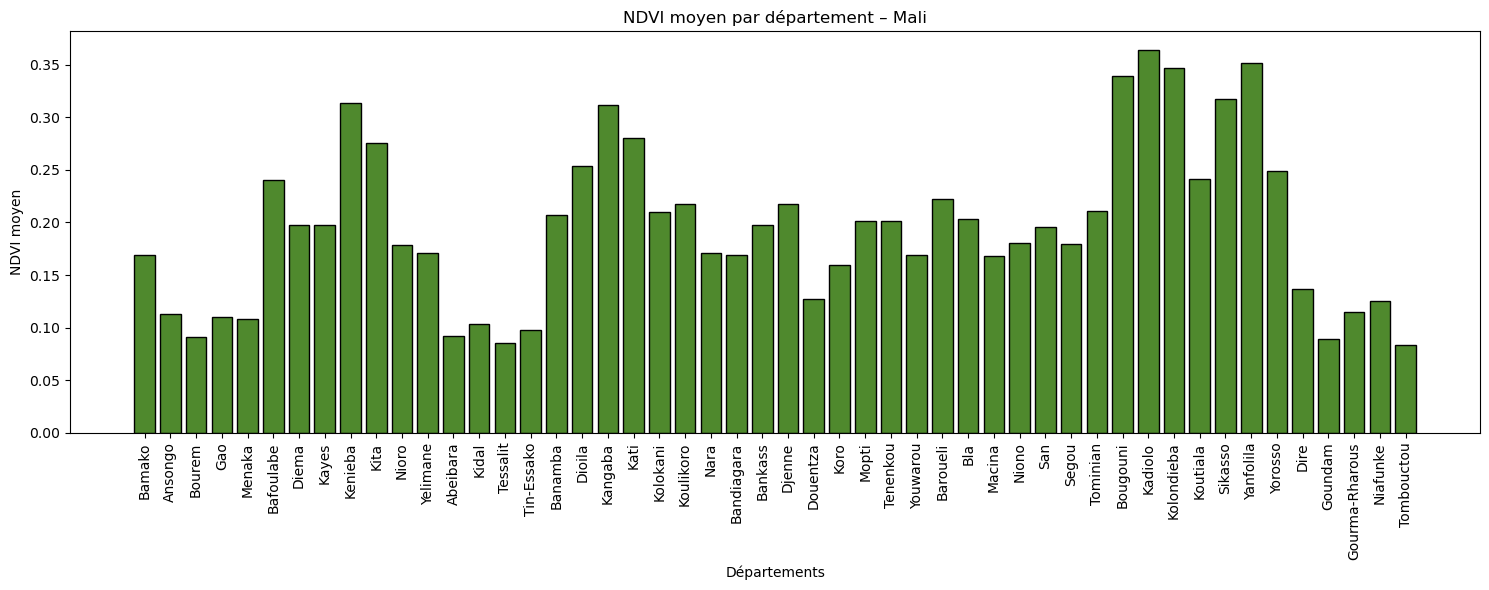

Table départementale NDVI enregistrée dans outputs/NDVI/


In [2]:
# ======================================================
# NDVI.ipynb – Calcul et analyse exploratoire du NDVI
# ======================================================

import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.mask import mask
from matplotlib.colors import ListedColormap, BoundaryNorm

# Chemins
BASE_DIR = os.getcwd()  # tp/scripts
DATA_DIR = os.path.join(BASE_DIR, "..", "data")
OUTPUT_DIR = os.path.join(BASE_DIR, "..", "outputs", "NDVI")
os.makedirs(OUTPUT_DIR, exist_ok=True)

path_b4 = os.path.join(DATA_DIR, "Mali_2022_B4_100m.tif")  # Rouge
path_b8 = os.path.join(DATA_DIR, "Mali_2022_B8_100m.tif")  # NIR

# Lecture des rasters
with rasterio.open(path_b4) as src:
    red = src.read(1).astype("float32")
    profile = src.profile

with rasterio.open(path_b8) as src:
    nir = src.read(1).astype("float32")

# Calcul NDVI
np.seterr(divide='ignore', invalid='ignore')
ndvi = (nir - red) / (nir + red)
ndvi = np.where((ndvi < -1) | (ndvi > 1), np.nan, ndvi)

# Palette NDVI
ndvi_bounds = [-1, -0.5, -0.2, -0.1, 0, 0.025, 0.05, 0.075, 0.1, 0.125,
               0.15, 0.175, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5,
               0.55, 0.6, 1]
ndvi_colors = [
    "#1a1a1a", "#666666", "#bfbfbf", "#dbdbdb", "#eaeaea", "#fff9cc",
    "#ede8b5", "#ddd89b", "#ccc682", "#bcb76b", "#afc160", "#a3cc59",
    "#91bf51", "#7fb247", "#70a33f", "#609635", "#4f892d", "#3f7c23",
    "#306d1c", "#216011", "#0f540a", "#004400"
]
cmap = ListedColormap(ndvi_colors)
norm = BoundaryNorm(ndvi_bounds, ncolors=cmap.N)

# ======================================================
# 1️⃣ Analyse nationale NDVI 
# ======================================================
mali_shape = gpd.read_file(os.path.join(DATA_DIR, "mli_admin0.shp"))
mali_shape = mali_shape.to_crs(profile['crs'])

plt.figure(figsize=(12, 10))
plt.imshow(ndvi, cmap=cmap, norm=norm)
mali_shape.boundary.plot(edgecolor="red", linewidth=1.5, ax=plt.gca())  # frontières
plt.colorbar(label="NDVI", boundaries=ndvi_bounds, ticks=ndvi_bounds)
plt.title("NDVI – Mali (2021–2022)")
plt.axis("off")
plt.savefig(os.path.join(OUTPUT_DIR, "NDVI_nationale.png"), dpi=300)
plt.show()

# Histogramme national
plt.figure(figsize=(8, 6))
plt.hist(ndvi[~np.isnan(ndvi)], bins=50, color="#4f892d", edgecolor="black")
plt.title("Distribution nationale du NDVI – Mali")
plt.xlabel("NDVI")
plt.ylabel("Fréquence")
plt.savefig(os.path.join(OUTPUT_DIR, "NDVI_histogramme_nationale.png"), dpi=300)
plt.show()

# ======================================================
# 2️⃣ Analyse régionale (Admin1)
# ======================================================
gadm1 = gpd.read_file(os.path.join(DATA_DIR, "mli_admin1.shp"))
gadm1 = gadm1.to_crs(profile['crs'])
regional_ndvi = []

for idx, row in gadm1.iterrows():
    geom = [row['geometry']]
    with rasterio.open(path_b4) as src:
        red_clip, _ = mask(src, geom, crop=True)
    with rasterio.open(path_b8) as src:
        nir_clip, _ = mask(src, geom, crop=True)
    red_clip = red_clip[0].astype("float32")
    nir_clip = nir_clip[0].astype("float32")
    ndvi_clip = (nir_clip - red_clip) / (nir_clip + red_clip)
    ndvi_clip = np.where((ndvi_clip < -1) | (ndvi_clip > 1), np.nan, ndvi_clip)
    regional_ndvi.append(np.nanmean(ndvi_clip))

gadm1['NDVI'] = regional_ndvi

# Carte régionale
gadm1.plot(column='NDVI', cmap=cmap, edgecolor='black', legend=True,
           legend_kwds={'label': "NDVI", 'orientation': "vertical"})
plt.title("NDVI moyen par région – Mali")
plt.savefig(os.path.join(OUTPUT_DIR, "NDVI_regionale.png"), dpi=300)
plt.show()

# Histogramme régional (bar plot)
plt.figure(figsize=(12, 6))
plt.bar(gadm1['shapeName'], gadm1['NDVI'], color="#4f892d", edgecolor="black")
plt.xticks(rotation=90)
plt.title("NDVI moyen par région – Mali")
plt.xlabel("Régions")
plt.ylabel("NDVI moyen")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "NDVI_histogramme_regionale.png"), dpi=300)
plt.show()

# ======================================================
# 3️⃣ Analyse départementale (Admin2)
# ======================================================
gadm2 = gpd.read_file(os.path.join(DATA_DIR, "mli_admin2.shp"))
gadm2 = gadm2.to_crs(profile['crs'])
dept_ndvi = []

for idx, row in gadm2.iterrows():
    geom = [row['geometry']]
    with rasterio.open(path_b4) as src:
        red_clip, _ = mask(src, geom, crop=True)
    with rasterio.open(path_b8) as src:
        nir_clip, _ = mask(src, geom, crop=True)
    red_clip = red_clip[0].astype("float32")
    nir_clip = nir_clip[0].astype("float32")
    ndvi_clip = (nir_clip - red_clip) / (nir_clip + red_clip)
    ndvi_clip = np.where((ndvi_clip < -1) | (ndvi_clip > 1), np.nan, ndvi_clip)
    dept_ndvi.append(np.nanmean(ndvi_clip))

gadm2['NDVI'] = dept_ndvi

# Carte départementale
gadm2.plot(column='NDVI', cmap=cmap, edgecolor='black', legend=True,
           legend_kwds={'label': "NDVI", 'orientation': "vertical"})
plt.title("NDVI moyen par département – Mali")
plt.savefig(os.path.join(OUTPUT_DIR, "NDVI_departementale.png"), dpi=300)
plt.show()

# Bar plot NDVI départemental
plt.figure(figsize=(15, 6))
plt.bar(gadm2['shapeName'], gadm2['NDVI'], color="#4f892d", edgecolor="black")
plt.xticks(rotation=90)
plt.title("NDVI moyen par département – Mali")
plt.xlabel("Départements")
plt.ylabel("NDVI moyen")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "NDVI_bar_departements.png"), dpi=300)
plt.show()

# ======================================================
# 4️⃣ Enregistrer la table départementale NDVI (CSV)
# ======================================================
ndvi_table = gadm2[['shapeName', 'NDVI']].copy()
ndvi_table.to_csv(os.path.join(OUTPUT_DIR, "NDVI_departements.csv"), index=False)
print("Table départementale NDVI enregistrée dans outputs/NDVI/")
